In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense,
    Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score,
    recall_score, f1_score, cohen_kappa_score
)
import seaborn as sns
tf.config.set_visible_devices([], 'GPU')


In [2]:
TRAIN_DIR = "/content/drive/MyDrive/Rice leaf/train"
TEST_DIR  = "/content/drive/MyDrive/Rice leaf/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_gen.num_classes
CLASS_NAMES = list(train_gen.class_indices.keys())


Found 8800 images belonging to 10 classes.
Found 2199 images belonging to 10 classes.
Found 1760 images belonging to 10 classes.


In [9]:
input_layer = Input(shape=(224,224,3))


efficientnet = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=input_layer
)
efficientnet.trainable = False


x = GlobalAveragePooling2D()(efficientnet.output)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,416,813 (16.85 MB)

 Trainable params: 364,682 (1.39 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [11]:

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]


In [12]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 3766s 7s/step - accuracy: 0.1006 - loss: 2.3762 - val_accuracy: 0.1332 - val_loss: 2.2956 - learning_rate: 1.0000e-04
Epoch 2/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 1115s 2s/step - accuracy: 0.1168 - loss: 2.3183 - val_accuracy: 0.1414 - val_loss: 2.2800 - learning_rate: 1.0000e-04
Epoch 3/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 1095s 2s/step - accuracy: 0.1229 - loss: 2.3116 - val_accuracy: 0.1232 - val_loss: 2.2790 - learning_rate: 1.0000e-04
Epoch 4/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 1086s 2s/step - accuracy: 0.1324 - loss: 2.2995 - val_accuracy: 0.1332 - val_loss: 2.2669 - learning_rate: 1.0000e-04
Epoch 5/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 1099s 2s/step - accuracy: 0.1304 - loss: 2.2846 - val_accuracy: 0.1282 - val_loss: 2.2657 - learning_rate: 1.0000e-04
Epoch 6/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 1098s 2s/step - accuracy: 0.1417 - loss: 2.2754 - val_accuracy: 0.1482 - val_loss: 2.2590 - learning_rate: 1.0000e-04
Epoch 7/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 1106s 2s/ste

In [13]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)


110/110 ━━━━━━━━━━━━━━━━━━━━ 587s 5s/step - accuracy: 0.1951 - loss: 2.0654
Test Accuracy: 0.145454540848732


In [14]:
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall    = recall_score(y_true, y_pred, average="weighted")
f1        = f1_score(y_true, y_pred, average="weighted")
kappa     = cohen_kappa_score(y_true, y_pred)

print("\n=== MODEL PERFORMANCE ===")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)
print("Kappa    :", kappa)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


110/110 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step

=== MODEL PERFORMANCE ===
Accuracy : 0.14545454545454545
Precision: 0.1895442382548089
Recall   : 0.14545454545454545
F1-score : 0.08773738284593978
Kappa    : 0.0505050505050505

Classification Report:

                       precision    recall  f1-score   support

bacterial_leaf_blight       0.00      0.00      0.00       176
           brown_spot       0.11      0.92      0.20       176
              healthy       0.08      0.06      0.07       176
           leaf_blast       0.00      0.00      0.00       176
           leaf_scald       0.00      0.00      0.00       176
    narrow_brown_spot       0.00      0.00      0.00       176
           neck_blast       1.00      0.06      0.11       176
           rice_hispa       0.24      0.06      0.09       176
        sheath_blight       0.46      0.36      0.40       176
               tungro       0.00      0.00      0.00       176

             accuracy                           0.15      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

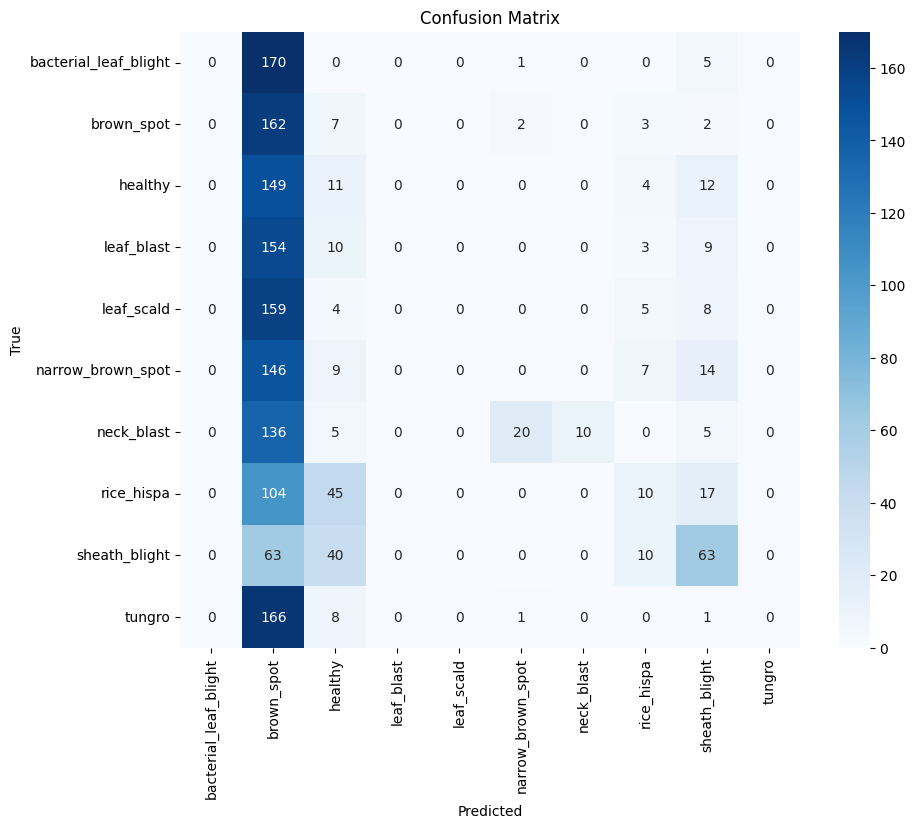

In [17]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



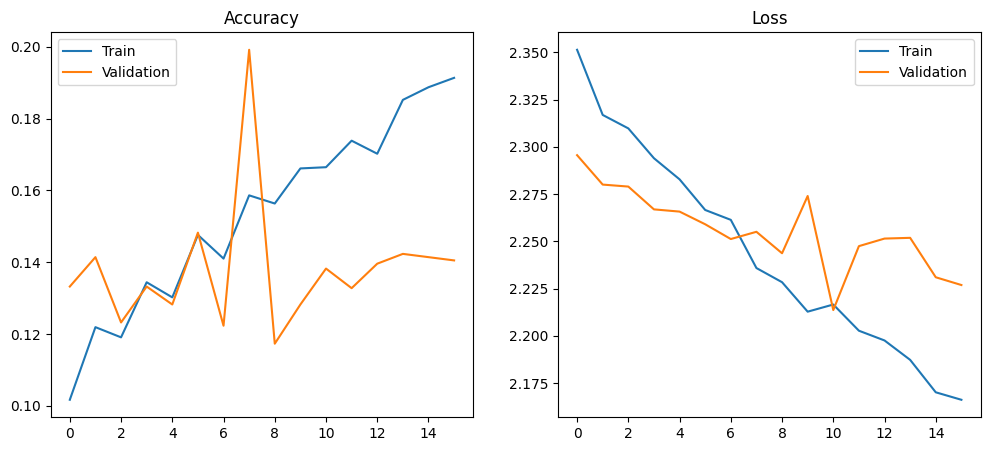

In [18]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Predicted class index: 1
Predicted class name: healthy
Confidence: 0.11562019


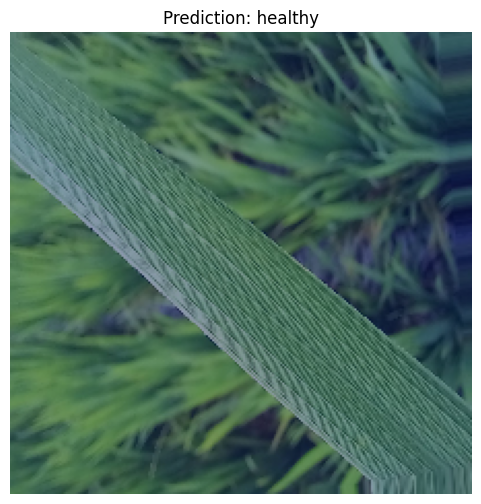

In [23]:

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
class_names = [
    "brown_spot",
    "healthy",
    "leaf_blast",
    "neck_blast"
]
def get_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name):

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)

    return heatmap
img_path = "/content/drive/MyDrive/Rice leaf/test/healthy/healthy465.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0
preds = model.predict(img_array)
class_index = np.argmax(preds[0])

print("Predicted class index:", class_index)
print("Predicted class name:", class_names[class_index])
print("Confidence:", preds[0][class_index])
last_conv_layer_name = "top_conv"  # EfficientNet last conv layer
heatmap = get_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name)
original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (224, 224))

heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {class_names[class_index]}")
plt.axis("off")
plt.show()
